In [179]:
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import seaborn as sn

from sportsreference.nba.boxscore import Boxscore
from sportsreference.nba.roster import Roster, Player
from sportsreference.nba.schedule import Schedule
from sportsreference.nba.teams import Teams

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [45]:
df_season = pd.read_csv('data/nba_player_stats_by_season.csv')
df_career = pd.read_csv('data/nba_player_stats_by_career.csv')

In [454]:
player = Player('garneke01')
salary = player.contract
salary
team = player._team_abbreviation[-1]
salary

In [452]:
player = Player('hardeja01')
salary = player.contract
team = player._team_abbreviation[-2]
sal_nums = [str(x).replace(',','').replace('$','') for x in list(salary.values())]
contract_total = np.sum([int(x) for x in sal_nums])
#sal_sum = sum(int(sal_nums))
player_df = player.dataframe

print(team)
print(sal_nums[0])
#print(np.sum([int(x) for x in str(salary.values()).replace(',','').replace('$','')]))
#print(len(player.contract.keys()))

print(player.contract['2020-21'])

player_df = player.dataframe
years_played = list(filter(lambda x: x != 'Career', player_df.salary.reset_index().iloc[:,0].to_list()))
print(years_played)
player_df['avg_salary'] = player.salary / len(years_played)
print(player_df['avg_salary'])

player_df['years_played'] = len(years_played)
#print(player_df['years_played'])

player_df['year_list'] = str(years_played)
print(player_df['year_list'])

player_df['current_player'] = player_df['year_list'].str.contains('2020-21')
#print(player_df[player_df['current_player'] == True])
print(player_df['current_player'])

player_df['current_salary'] = player.contract['2020-21']
#print(player_df['current_salary'])

player_df['current_avg_salary'] = contract_total / len(sal_nums)
#print(player_df['current_avg_salary'])


TOT
40824000
$40,824,000
['2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']
2009-10    1.553590e+07
2010-11    1.553590e+07
2011-12    1.553590e+07
2012-13    1.553590e+07
2013-14    1.553590e+07
2014-15    1.553590e+07
2015-16    1.553590e+07
2016-17    1.553590e+07
2017-18    1.553590e+07
2018-19    1.553590e+07
2019-20    1.553590e+07
2020-21    1.553590e+07
Career     1.553590e+07
Name: avg_salary, dtype: float64
2009-10    ['2009-10', '2010-11', '2011-12', '2012-13', '...
2010-11    ['2009-10', '2010-11', '2011-12', '2012-13', '...
2011-12    ['2009-10', '2010-11', '2011-12', '2012-13', '...
2012-13    ['2009-10', '2010-11', '2011-12', '2012-13', '...
2013-14    ['2009-10', '2010-11', '2011-12', '2012-13', '...
2014-15    ['2009-10', '2010-11', '2011-12', '2012-13', '...
2015-16    ['2009-10', '2010-11', '2011-12', '2012-13', '...
2016-17    ['2009-10', '2010-11', '2011-12', '2012-13', '...
2017-18  

In [315]:
hard = Player('hardeja01')
hard_df = hard.dataframe
hard_df.salary.reset_index().iloc[:,0].to_list()

['2009-10',
 '2010-11',
 '2011-12',
 '2012-13',
 '2013-14',
 '2014-15',
 '2015-16',
 '2016-17',
 '2017-18',
 '2018-19',
 '2019-20',
 '2020-21',
 'Career']

In [312]:
hardsal = hard_df.salary.reset_index()
#hardsal = hardsal.reset_index()
total_earnings = hardsal[hardsal.iloc[:,0] == 'Career']
print(total_earnings)
hardsal = hardsal[hardsal.iloc[:,0] != 'Career']
years_lst = hardsal.iloc[:,0].to_list()
#ser = pd.Series(hardsal['year'])
#hardsal['currently_playing'] = hardsal['year'].isin(years_lst)
print(years_lst)
hardsal

   level_0       salary
12  Career  186430742.0
['2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']


,level_0,salary
0,2009-10,4054160.0
1,2010-11,4304520.0
2,2011-12,4604760.0
3,2012-13,5820417.0
4,2013-14,13701250.0
5,2014-15,14728844.0
6,2015-16,15756438.0
7,2016-17,26540100.0
8,2017-18,28299399.0
9,2018-19,30421854.0


## Dropping columns with all null or useless values

In [41]:
for col in df_career.columns:
    unique = df_career[col].unique()
    val = len(unique)
    if val < 20:
        print(f'{col}: has {val} values')
        print(f'Values include:')
        print(f'     {unique}')

# df_career['center_percentage'].unique()

center_percentage: has 1 values
Values include:
     [0]
half_court_heaves_made: has 7 values
Values include:
     [0. 1. 2. 3. 6. 4. 5.]
point_guard_percentage: has 1 values
Values include:
     [0]
position: has 11 values
Values include:
     ['PG' 'SF' 'C' 'SG' 'PF' 'C,PF' nan 'C,SF' 'PF,SF' 'PG,SG' 'SF,SG']
power_forward_percentage: has 1 values
Values include:
     [0]
shooting_guard_percentage: has 1 values
Values include:
     [0]
small_forward_percentage: has 1 values
Values include:
     [0]
year: has 1 values
Values include:
     ['Career']


In [49]:
nulls = ['and_ones', 'blocking_fouls', 'dunks', 'lost_ball_turnovers',
'net_plus_minus', 'offensive_fouls', 'on_court_plus_minus',
'other_turnovers', 'passing_turnovers', 'percentage_field_goals_as_dunks',
'percentage_of_three_pointers_from_corner', 'percentage_shots_three_pointers',
'percentage_shots_two_pointers', 'points_generated_by_assists',
'shooting_fouls', 'shooting_fouls_drawn', 'shots_blocked',
'take_fouls', 'team_abbreviation', 'three_point_shot_percentage_from_corner',
'three_pointers_assisted_percentage', 'two_pointers_assisted_percentage',
'age', 'center_percentage', 'point_guard_percentage',
'power_forward_percentage', 'shooting_guard_percentage',
'small_forward_percentage', 'year', 'player_id']

In [47]:
df_career = df_career.drop(['and_ones', 'blocking_fouls', 'dunks', 'lost_ball_turnovers',
'net_plus_minus', 'offensive_fouls', 'on_court_plus_minus',
'other_turnovers', 'passing_turnovers', 'percentage_field_goals_as_dunks',
'percentage_of_three_pointers_from_corner', 'percentage_shots_three_pointers',
'percentage_shots_two_pointers', 'points_generated_by_assists',
'shooting_fouls', 'shooting_fouls_drawn', 'shots_blocked',
'take_fouls', 'team_abbreviation', 'three_point_shot_percentage_from_corner',
'three_pointers_assisted_percentage', 'two_pointers_assisted_percentage',
'age', 'center_percentage', 'point_guard_percentage',
'power_forward_percentage', 'shooting_guard_percentage',
'small_forward_percentage', 'year', 'player_id'], axis=1)

## Dropping Rows(players)

In [53]:
# Also going to drop players that don't have any recorded salary
df_career = df_career.dropna(subset=['salary'])

In [54]:
# And players whos salary appeared as $0.0 for some reason
df_career = df_career[df_career['salary'] > 0]

In [63]:
# Checking for players with the same name
name_counts = df_career.groupby('name')['name'].count()
name_counts.sort_values(ascending=False)

name
Dee Brown            2
Marcus Williams      2
Chris Johnson        2
Mike James           2
Fred Vinson          1
                    ..
Michael Dickerson    1
Michael Doleac       1
Michael Finley       1
Michael Frazier      1
A.C. Green           1
Name: name, Length: 1919, dtype: int64

In [130]:
# Double-checking that the double_names are actually unique players (Spoiler Alert: they are)
#double_names = ['Dee Brown', 'Marcus Williams', 'Chris Johnson', 'Mike James']
#df_career[df_career['name'].isin(double_names)]

In [73]:
# Setting index to id since there is some players with multiple players with the same name
df_career['id'] = df_career['id'].str.split(' ').str[0]
df_career = df_career.set_index('id')

In [80]:
def to_inches(height):
    feet, inches = str(height).split('-')
    return (int(feet)*12) + int(inches)

In [84]:
df_career['height'] = df_career['height'].apply(to_inches)

In [85]:
df_career['height']

id
bareajo01    70
broekry01    78
brunsja01    73
burketr01    72
caulewi01    84
             ..
murdoer01    73
anstech01    84
armstbj01    74
reevekh01    75
willode01    75
Name: height, Length: 1923, dtype: int64

In [94]:
player_ids = df_career.index.values
player_ids

array(['bareajo01', 'broekry01', 'brunsja01', ..., 'armstbj01',
       'reevekh01', 'willode01'], dtype=object)

## Filling NaNs

In [137]:
df_career.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1923 entries, bareajo01 to willode01
Data columns (total 65 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   assist_percentage                               1923 non-null   float64
 1   assists                                         1923 non-null   float64
 2   block_percentage                                1923 non-null   float64
 3   blocks                                          1923 non-null   float64
 4   box_plus_minus                                  1923 non-null   float64
 5   defensive_box_plus_minus                        1923 non-null   float64
 6   defensive_rebound_percentage                    1923 non-null   float64
 7   defensive_rebounds                              1923 non-null   float64
 8   defensive_win_shares                            1923 non-null   float64
 9   effective_field_goal_percentage  

In [156]:
# Grabbing players that are not currently assigned positions
unpositioned_players = df_career[df_career['position'].isna()]
unpositioned_players

,assist_percentage,assists,block_percentage,blocks,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,defensive_rebounds,defensive_win_shares,effective_field_goal_percentage,...,two_point_percentage,two_pointers,usage_percentage,value_over_replacement_player,weight,win_shares,win_shares_per_48_minutes,birth_date,name,salary_per_game
id,,,,,,,,,,,,,,,,,,,,,


In [132]:
df_career = df_career.fillna(0)

In [150]:
avgs = ['assist_percentage', 'block_percentage', 'box_plus_minus',
'defensive_box_plus_minus', 'defensive_rebound_percentage', 'effective_field_goal_percentage',
'field_goal_percentage', 'field_goal_perc_sixteen_foot_plus_two_pointers',
'field_goal_perc_ten_to_sixteen_feet', 'field_goal_perc_three_to_ten_feet',
'field_goal_perc_zero_to_three_feet', 'field_goal_percentage',
'free_throw_attempt_rate', 'free_throw_percentage', 'offensive_box_plus_minus',
'offensive_rebound_percentage', 'player_efficiency_rating',
'three_point_percentage', 'total_rebound_percentage', 'true_shooting_percentage'
'turnover_percentage', 'two_point_percentage', 'usage_percentage',
'win_shares', 'win_shares_per_48_minutes']

df_avgs = df_career[['assist_percentage', 'block_percentage', 'box_plus_minus',
'defensive_box_plus_minus', 'defensive_rebound_percentage', 'effective_field_goal_percentage',
'field_goal_percentage', 'field_goal_perc_sixteen_foot_plus_two_pointers',
'field_goal_perc_ten_to_sixteen_feet', 'field_goal_perc_three_to_ten_feet',
'field_goal_perc_zero_to_three_feet', 'field_goal_percentage',
'free_throw_attempt_rate', 'free_throw_percentage', 'offensive_box_plus_minus',
'offensive_rebound_percentage', 'player_efficiency_rating',
'three_point_percentage', 'total_rebound_percentage', 'true_shooting_percentage',
'turnover_percentage', 'two_point_percentage', 'usage_percentage',
'win_shares', 'win_shares_per_48_minutes']]
df_avgs.head()

,assist_percentage,block_percentage,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,effective_field_goal_percentage,field_goal_percentage,field_goal_perc_sixteen_foot_plus_two_pointers,field_goal_perc_ten_to_sixteen_feet,field_goal_perc_three_to_ten_feet,...,offensive_rebound_percentage,player_efficiency_rating,three_point_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,two_point_percentage,usage_percentage,win_shares,win_shares_per_48_minutes
id,,,,,,,,,,,,,,,,,,,,,
bareajo01,33.2,0.1,-0.7,-1.4,10.4,0.485,0.424,0.398,0.417,0.364,...,1.7,14.5,0.352,6.0,0.515,14.9,0.462,23.4,23.8,0.070
broekry01,7.5,1.1,-0.5,-0.3,15.5,0.584,0.427,1.000,0.143,0.375,...,2.2,11.4,0.403,8.9,0.604,10.1,0.512,14.8,1.2,0.093
brunsja01,23.0,0.2,-1.0,-0.8,11.2,0.543,0.484,0.447,0.498,0.460,...,1.8,14.5,0.364,6.6,0.574,12.7,0.542,19.7,7.4,0.099
burketr01,25.0,0.4,-1.1,-1.6,8.0,0.475,0.412,0.434,0.428,0.359,...,1.8,14.0,0.348,4.9,0.502,10.5,0.449,23.0,12.7,0.063
caulewi01,10.1,3.2,0.0,0.6,21.3,0.544,0.543,0.368,0.336,0.362,...,8.0,16.8,0.185,14.5,0.563,10.3,0.546,17.4,22.2,0.121


In [87]:
non_stats = ['nationality', 'player_id', 'position', 'birth_date', 'name']

In [157]:
# Creating seperate DFs for different use cases
df_career_no_salaries = df_career.drop(['salary'], axis=1)
df_pure_stats = df_career.drop(non_stats, axis=1)
df_pure_stats_no_salary = df_pure_stats.drop(['salary'], axis=1)

In [163]:
df_pure_stats

,assist_percentage,assists,block_percentage,blocks,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,defensive_rebounds,defensive_win_shares,effective_field_goal_percentage,...,turnovers,two_point_attempts,two_point_percentage,two_pointers,usage_percentage,value_over_replacement_player,weight,win_shares,win_shares_per_48_minutes,salary_per_game
id,,,,,,,,,,,,,,,,,,,,,
bareajo01,33.2,3270.0,0.1,24.0,-0.7,-1.4,10.4,1495.0,10.1,0.485,...,1264.0,4355.0,0.462,2013.0,23.4,5.3,180,23.8,0.070,47099.774970
broekry01,7.5,33.0,1.1,8.0,-0.5,-0.3,15.5,93.0,0.5,0.584,...,22.0,41.0,0.512,21.0,14.8,0.2,215,1.2,0.093,38225.694915
brunsja01,23.0,548.0,0.2,8.0,-1.0,-0.8,11.2,384.0,2.2,0.543,...,209.0,882.0,0.542,478.0,19.7,0.9,190,7.4,0.099,15569.717647
burketr01,25.0,1447.0,0.4,48.0,-1.1,-1.6,8.0,677.0,4.6,0.475,...,519.0,2664.0,0.449,1195.0,23.0,2.1,185,12.7,0.063,36313.837529
caulewi01,10.1,579.0,3.2,317.0,0.0,0.6,21.3,1689.0,10.1,0.544,...,364.0,2736.0,0.546,1495.0,17.4,4.4,240,22.2,0.121,45645.723958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
murdoer01,34.3,2467.0,0.4,69.0,2.0,0.9,9.2,922.0,11.9,0.473,...,991.0,3447.0,0.462,1593.0,21.9,12.1,190,25.6,0.103,21943.405512
anstech01,11.0,127.0,2.2,65.0,-2.9,0.2,19.2,356.0,2.6,0.416,...,147.0,705.0,0.424,299.0,21.2,-0.5,249,2.8,0.062,18147.225806
armstbj01,20.9,2479.0,0.2,47.0,-0.2,-0.6,7.4,1129.0,13.4,0.513,...,889.0,4955.0,0.487,2414.0,18.4,8.1,175,45.0,0.121,21927.710843


In [129]:
# Adding column to show salary per game
#df_career['salary_per_game'] = df_career['salary'] / df_career['games_played']
#df_career[['salary_per_game', 'salary', 'games_played']].sort_values('salary_per_game', ascending=False)

## Normalizing approach

In [162]:
x = df_pure_stats.values
x.shape

(1923, 60)

In [158]:
x = df_pure_stats.values
min_max_scalar = MinMaxScaler()
x_scaled = min_max_scalar.fit_transform(x)
df_pure_stats_normalized = pd.DataFrame(x_scaled)

In [243]:
x = df_pure_stats_normalized.values
x.shape[1]

60

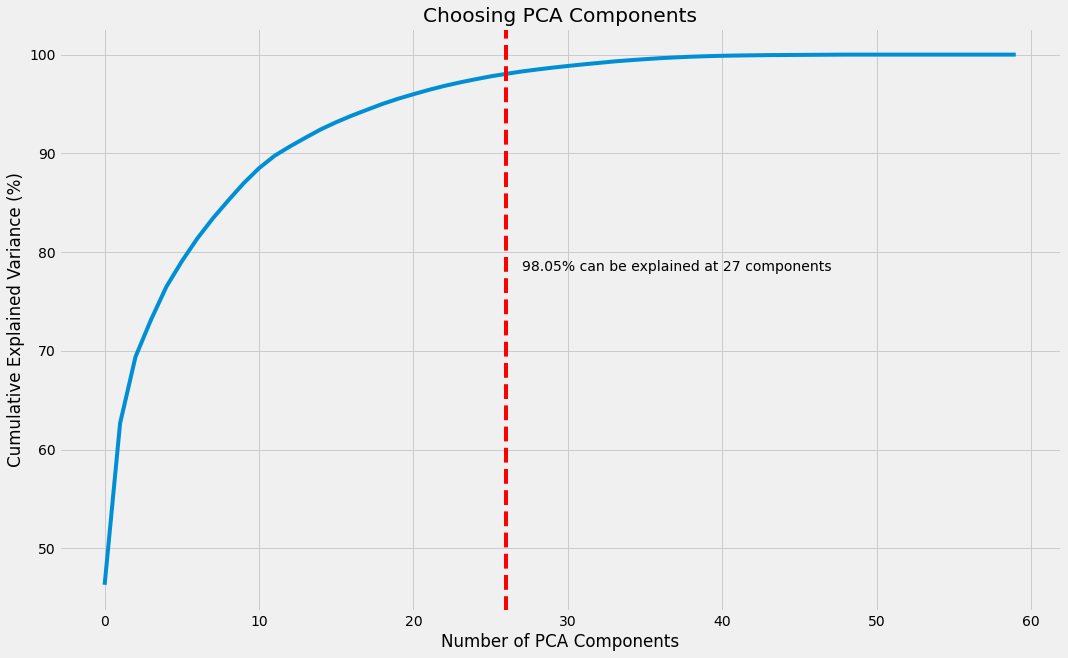

In [270]:
pca = PCA(x.shape[1])
pca.fit(x)
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
var_to_beat = np.argwhere(var1 >= 98)
var_explained = np.round(var1[var_to_beat[0]], decimals=2)[0]
comps = var_to_beat.flatten()[1]

fig, ax = plt.subplots(figsize=(16,10))

ax.plot(var1)
ax.set_title('Choosing PCA Components')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Cumulative Explained Variance (%)')
ax.axvline(var_to_beat[0], c='r', linestyle='--')
ax.annotate(f'{var_explained}% can be explained at {comps} components', xy=(comps, var_explained-20))

#plt.savefig('images/pca_graph.png')

In [182]:
# 27 variables explain 98.05% of the variance

In [213]:
def find_best_cluster_amount(x, loops):
    d = {}
    for i in range(loops):
        after_pca = PCA(n_components=27, whiten=True).fit_transform(x)
        k_range = range(2,16)
        k_means_var = [KMeans(n_clusters=k).fit(after_pca) for k in k_range]
        labels = [i.labels_ for i in k_means_var]
        sil_score = [silhouette_score(after_pca, i, metric='cosine') for i in labels]
        centroids = [i.cluster_centers_ for i in k_means_var]
        k_euclid = [cdist(after_pca,cent,'cosine') for cent in centroids]
        dist = [np.min(ke, axis=1) for ke in k_euclid]
        wcss = [sum(d**2) for d in dist]
        tss = sum(pdist(after_pca)**2/after_pca.shape[0])
        bss = tss - wcss
        
        sil_arr = np.transpose(sil_score)*100
        max_score = np.max(sil_arr)
        max_score_index = np.argmax(sil_arr == max_score)
        
        if max_score_index in d:
            d[max_score_index] += 1
        else:
            d[max_score_index] = 1
    
    return d

In [215]:
d_clusters = find_best_cluster_amount(x, 50)

{10: 3, 4: 4, 6: 14, 5: 11, 7: 9, 12: 2, 8: 6, 9: 1}

In [227]:
d_clusters = {10: 3, 4: 4, 6: 14, 5: 11, 7: 9, 12: 2, 8: 6, 9: 1}
d_clusters = dict(sorted(d_clusters.items(), key=lambda item: item[1], reverse=True))
print(d_clusters)
print(f'Number of Clusters: {d_clusters.keys()}')
print(f'Number of Clusters: {d_clusters.values()}')

{6: 14, 5: 11, 7: 9, 8: 6, 4: 4, 10: 3, 12: 2, 9: 1}
Number of Clusters: dict_keys([6, 5, 7, 8, 4, 10, 12, 9])
Number of Clusters: dict_values([14, 11, 9, 6, 4, 3, 2, 1])


dict_keys

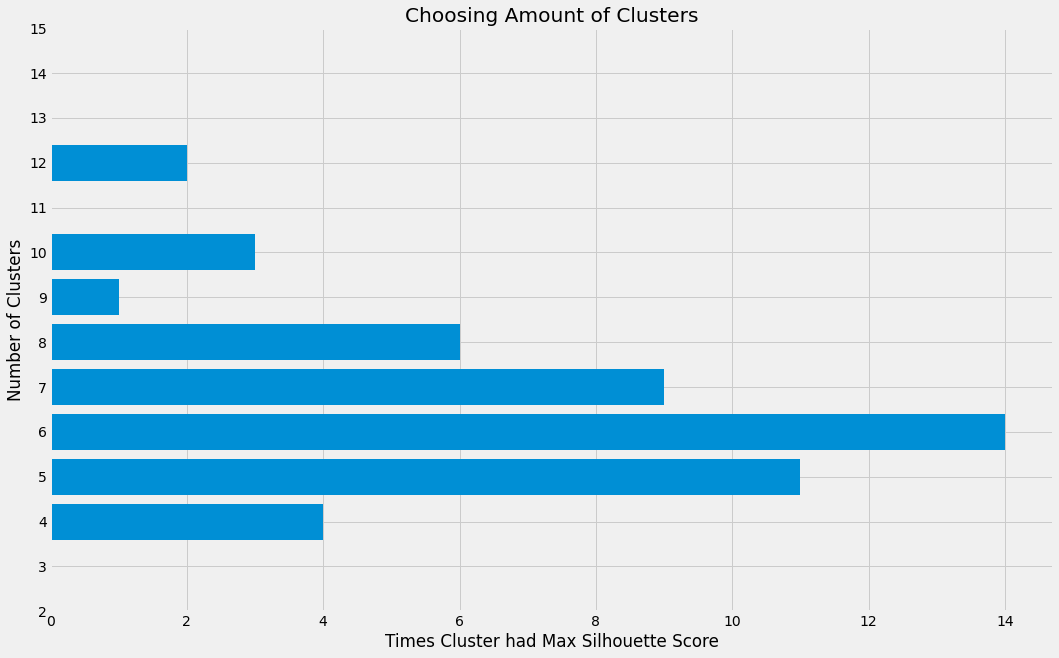

In [234]:
d_clusters = dict(sorted(d_clusters.items(), key=lambda item: item[1], reverse=True))

fig, ax = plt.subplots(figsize=(16,10))

ax.barh(list(d_clusters.keys()), list(d_clusters.values()))
ax.set_title('Choosing Amount of Clusters')
ax.set_xlabel('Times Cluster had Max Silhouette Score')
ax.set_ylabel('Number of Clusters')
ax.set_yticks(np.arange(2,16))

fig = ax.figure
fig.set_size_inches(16,10)
fig.tight_layout(pad=1)
#fig.savefig('images/number_of_clusters_graph.png')

<Figure size 432x288 with 0 Axes>

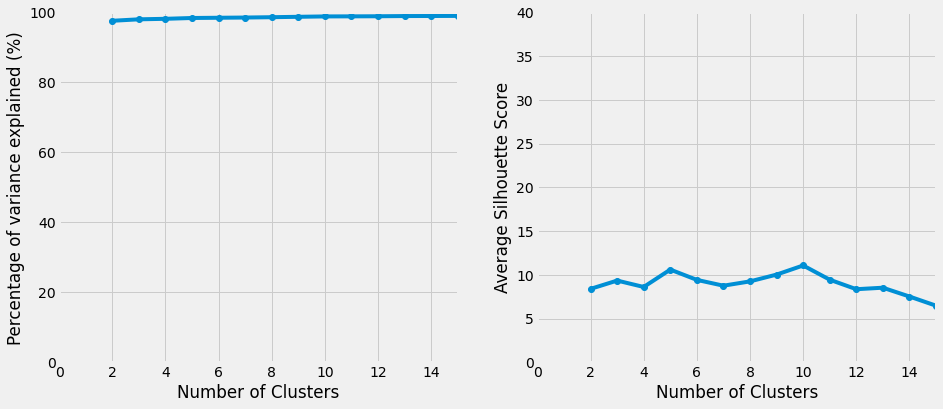

In [197]:
plt.clf()
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(k_range, bss/tss*100, 'o-')
plt.axis([0, np.max(k_range), 0, 100])
plt.xlabel('Number of Clusters')
plt.ylabel('Percentage of variance explained (%)');

plt.subplot(1,2,2)
plt.plot(k_range, np.transpose(sil_score)*100, 'o-')
plt.axis([0, np.max(k_range), 0, 40])
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score');